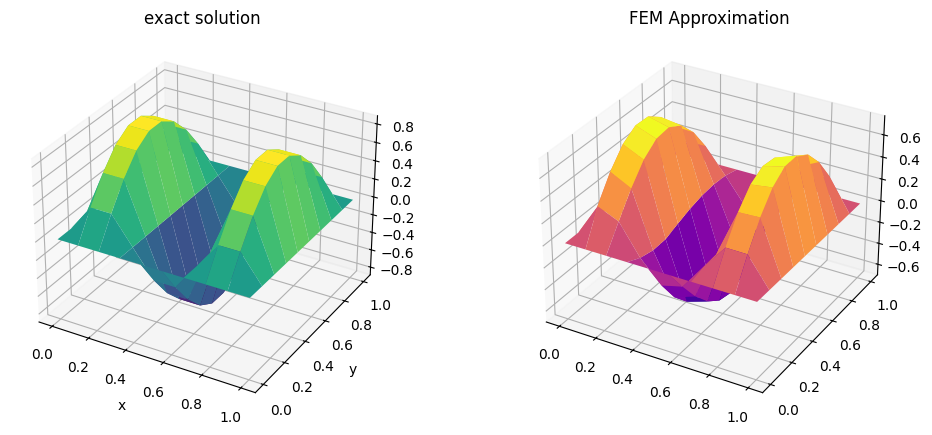

In [ ]:
# Copyright (c) Octavius Guenther 2025
# All rights preserved

import numpy as np

from numpy.linalg import det,inv
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve


def h11e03_getTriangulationMatrices(N):
    
    #schrittlaenge
    h = 1/(N+1)

    #number of nodes
    nn = (N+2)**2

    x = np.arange(0,1+h,h)
    y = np.arange(0,1+h,h)

    X,Y = np.meshgrid(x,y)

    #matrix B
    #coordinates of nodes x_i,y_i
    B = np.array([X.reshape(nn,),Y.reshape(nn,)]).T

    #matrix D
    #indicating boundary values  
    b1 = (B[:,0] == 0) | (B[:,0] == 1)
    b2 = (B[:,1] == 0) | (B[:,1] == 1)

    D = b1 | b2

    #matrix C
    #nodes of the triangles
    seq = np.array([*range(0,N+1)])
    seqseq = [seq + n*(N+2) for n in range(0,N+1)]
    first_column = np.hstack(seqseq)
    second_column = first_column + 1
    third_column = second_column + (N+2)

    upper = np.vstack([first_column,second_column,third_column]).T

    lower = np.vstack([first_column,first_column + (N+2),third_column]).T

    C = np.vstack([upper,lower])

    #matrix E 
    #centroid of the triangles
    E = np.array([np.sum(B[C[i]],axis = 0) for i in range(0,len(C))])

    return B,C,D,E

def h12e03_getGalerkinSystem(f, N):

    #precalculated integrals in aij_l
    Sxx = (1/2)*np.array([[1,-1,0],[-1,1,0],[0,0,0]])
    Sxy = (1/2)*np.array([[2,-1,-1],[-1,0,1],[-1,1,0]])
    Syy = (1/2)*np.array([[1,0,-1],[0,0,0],[-1,0,1]])


    #B - coordinates of all nodes
    #C - indices of nodes of triangles
    #D - indicator of boundary node
    #E - coordinates of centroids
    B,C,D,E = h11e03_getTriangulationMatrices(N)

    #number of vertices/nodes
    n_v = len(B)

    #MOST IMPORTANT: DOF LOCAL TO GLOBAL
    #number of all triangles
    n_t = len(C)

    #initialize An,fn
    

    fn = np.zeros((n_v,))

    
    inner_nodes = np.where(~D)[0]
    map_global2local = {g: i for i, g in enumerate(inner_nodes)}

    rows, cols, vals = [], [], []

    #outer loop: over number of triangles
    for l in range(0,n_t):
        #access node indices
        kl1 = C[l][0]
        kl2 = C[l][1]
        kl3 = C[l][2]

        kl = [kl1,kl2,kl3]

        #x,y coordinates 
        x_kl1 = B[kl1][0]
        x_kl2 = B[kl2][0]
        x_kl3 = B[kl3][0]

        y_kl1 = B[kl1][1]
        y_kl2 = B[kl2][1]
        y_kl3 = B[kl3][1]

        F_l = np.array([[x_kl2 - x_kl1, x_kl3 - x_kl1],[y_kl2 - y_kl1, y_kl3 - y_kl1]])

        d_l = np.abs(det(F_l))
        
        B_l = inv(F_l) @ inv(F_l).T

        S_l = d_l * (B_l[0][0]* Sxx + B_l[1][1]*Syy + B_l[0][1]*Sxy)

        #inner loop: iterating over dof of reference triangle
        f_l = np.zeros(3,)
        for i in range(0,len(f_l)):
            if D[kl[i]]:
                continue
            #calculating rhs 

            ref_centroid = np.array([1/3 , 1/3])
            z_hat = (F_l @ ref_centroid + np.array([x_kl1, y_kl1]))
            f_l[i] = d_l*(1/6)*f(z_hat[0],z_hat[1])
           
            fn[kl[i]] = fn[kl[i]] + f_l[i]

            ii = map_global2local[kl[i]]

            #inner-inner loop: iterating over dof of reference triangle
            for j in range(0,3):
                if D[kl[j]]:
                    continue

                jj = map_global2local[kl[j]]
                rows.append(ii)
                cols.append(jj)
                vals.append(S_l[i,j])

                #An[kl[i]][kl[j]] = An[kl[i]][kl[j]] + S_l[i][j]

    fn = fn[~D]
    n_inner = np.sum(~D)
    An = coo_matrix((vals, (rows, cols)), shape=(n_inner, n_inner)).tocsr()

    #X,Y = np.meshgrid(D,D)
    #n_inner_nodes = np.sum(~D)
    #An = An[~(X | Y)].reshape((n_inner_nodes,n_inner_nodes))
    
    return An,fn

#rhs
f = lambda x,y : (10*np.pi**2)*np.sin(3*np.pi*x)*np.sin(np.pi*y)

#exact solution
u = lambda x,y : np.sin(3*np.pi*x)*np.sin(np.pi*y)

#determine Fl and the points if needed

          
# --- Function generated with ChatGPT (OpenAI), modified by Octavius Guenther #
def find_simplex_custom(B, C, x):
    """
    Findet das Dreieck, das den Punkt x = (x, y) enthält.


    Gibt den Index des Dreiecks zurück, oder -1 wenn keines passt.
    """
    px, py = x
    for l, (i, j, k) in enumerate(C):
        tri_pts = B[[i, j, k]]
        A = np.array([[tri_pts[1,0] - tri_pts[0,0], tri_pts[2,0] - tri_pts[0,0]],
                      [tri_pts[1,1] - tri_pts[0,1], tri_pts[2,1] - tri_pts[0,1]]])
        rhs = np.array([px - tri_pts[0,0], py - tri_pts[0,1]])
        lam = np.linalg.solve(A, rhs)
        l1, l2 = lam
        l3 = 1 - l1 - l2
        # Prüfen, ob baryzentrische Koordinaten im Dreieck liegen
        if (l1 >= 0) and (l2 >= 0) and (l3 >= 0):
            return l,np.array([l3,l1,l2])
    return -1

def find_k(B,C,z3,inner_nodes):
# find all indices of all inner nodes
    
    idx=np.where(np.all(np.isin(B,inner_nodes),axis = 1))
    idx[0]

    # find the corresponding global triangle where z3 lies
    # and return the barycentric coordinates

    l,bary = find_simplex_custom(B,C,z3)
    

    #nodes of the corresponding triangle

    #determine k by matching the nodes with the index of an inner node
    idx2 = np.where(np.isin(C[l], idx))

    return idx2[0]

def eval_uh(X,Y,B,C,inner_nodes,map_global2inner):


    #points of Z which is an array of pairs (x,y)
    Z = np.vstack([X.ravel(), Y.ravel()]).T

    N_points = Z.shape[0]

    #intialize U_h as a flat array
    U_h_flat = np.full(N_points, np.nan)

    for idx, (x, y) in enumerate(Z):
        z = np.array([x,y])
        l,bary = find_simplex_custom(B,C,z)
        k = find_k(B,C,z,inner_nodes)


        #map_global2inner[C[l][k][0]]
        #alpha[map_global2local[C[l][k]]] @ bary[k]

        #this just transforms the dictionary to a numpy array
        # --- Following two lines generated with ChatGPT (OpenAI), modified by Octavius Guenther ---
        map_array = np.full(max(map_global2inner)+1, -1, int)
        map_array[list(map_global2inner)] = list(map_global2inner.values())

        U_h_flat[idx] = alpha[map_array[C[l][k]]] @ (bary[k])
        
    
    U_h = U_h_flat.reshape(X.shape)

    return U_h

p = 3

N = np.power(2,p)-1

B,C,D,E = h11e03_getTriangulationMatrices(N)
inner_nodes = B[~D]
inner_nodes_indices = np.where(~D)[0]
map_global2inner = {g: i for i, g in enumerate(inner_nodes_indices)}

An,fn = h12e03_getGalerkinSystem(f,N)

alpha = spsolve(An,fn)


x = np.linspace(0,1,10)
X,Y = np.meshgrid(x,x)
Z = u(X,Y)

U_h = eval_uh(X,Y,B,C,inner_nodes,map_global2inner)
U_h


fig = plt.figure(figsize=(12, 5))

ax = fig.add_subplot(1,2,1, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')


ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('exact solution')

 #Zweiter Plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(X, Y, U_h, cmap='plasma')
ax2.set_title('FEM Approximation')

plt.show()